# Notebook 18:  Ising Configurations using Deep Boltzmann Machines

## Learning Goal
The goal of this notebook is to teach readers how to generate examples using Deep Boltzmann Machines in the Paysage package. The reader should understand why generating new examples is much tougher than classifying, as well as become more acquainted with pre-training using DBMs.

## Overview

The goal of this notebook is to show how one can employ Generative Models to learn a variational approximation to the probability distribution used to draw thermal spin configurations in the 2D Ising model.

The Hamiltonian for the classical Ising model is given by

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

where the lattice site indices $i,j$ run over all nearest neighbors of a $40\times 40$ 2D square lattice, and $J$ is some arbitrary interaction energy scale. We adopt periodic boundary conditions. Onsager proved that this model undergoes a phase transition in the thermodynamic limit from an ordered ferromagnet with all spins aligned to a disordered phase at the critical temperature $T_c/J=2/\log(1+\sqrt{2})\approx 2.26$. For any finite system size, this critical point is expanded to a critical region around $T_c$.

In previous notebooks, we used our knowledge of the critical point at $T_c/J\approx 2.26$ to label the spin configurations and study the problem of classifying the states according to their phase of matter. However, in more complicated models, where the precise position of $T_c$ is not known, one cannot label the states with such an accuracy, if at all. 

As we explained in Secs. XV and XVI of the review, generative models can be used to learn a variational approximation for the probability distribution that generated the data points. By using only the 2D spin configurations, we now want to train a deep Bernoulli Boltzmann machine, the fantasy particles of which are thermal Ising configurations. 

Unlike in previous studies of the Ising dataset, here we perform the analysis at a fixed temperature $T$. We can then apply our model at three different values $T=1.75,2.25,2.75$ in the ordered, critical and disordered regions, respectively.

## Setting up Paysage

In this notebook, we use an open-source `python` package for energy-based models, called [paysage](https://github.com/drckf/paysage). Paysage requires `python>3.5`; we recommend using the package with an [Anaconda](https://www.continuum.io/downloads) environment.

To install paysage: 

* clone or download the [github repo](https://github.com/drckf/paysage)
* activate an Anaconda3 environment
* navigate to the directory which contains the paysage files
* and execute
```
pip install .
```

Documentation for paysage is available under [https://github.com/drckf/paysage/tree/master/docs](https://github.com/drckf/paysage/tree/master/docs).

### Paysage on GPUs

By default, computations in paysage are performed using `numpy`/`numexpr`/`numba` on the CPU. Since the coputation below on the Ising dataset is more intensive compared to MNIST, we want to make use of a GPU speedup.

Not all laptops have GPUs available for computaion, but large computing facilities, such as supercomputing clusters, do. If you do not have access to a GPU, you can still run the code below with parameters corresponding to those used to generate the figurs in Sec. XVI F, but prepare for larger waiting times. As discussed in the main text, energy-based models rely on Monte-Carlo inspired methods rather than backpropagation. For this reason, they tend to be more computationally expensive than generative models.

To make use of GPU power, you need to install [PyTorch](https://pytorch.org), and switch to the `pytorch` backend by changing the setting in `paysage/backends/config.json` to `pytorch`. 

Let us set up the required packages for this notebook by importing the relevant paysage modules.

## Loading the Required Packages

In [1]:
import os
import pickle
import numpy as np

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.cm as cm
import seaborn as sns
# import ml_style as style
import matplotlib as mpl

# mpl.rcParams.update(style.style)

# for Boltzmann machines
from paysage import preprocess as pre
from paysage.layers import BernoulliLayer, GaussianLayer
from paysage.models import BoltzmannMachine
from paysage import batch
from paysage import fit
from paysage import optimizers
from paysage import samplers
from paysage import backends as be
from paysage import schedules
from paysage import penalties as pen

# fix random seed to ensure deterministic behavior
be.set_seed(137)

Running paysage with the python backend on the cpu


## Loading the Data

To load the Ising data set, we use two functions: `unpack_data()` loads the Ising configurations from a pickled file, and casts them in a suitable shape. 

The function `Load_Ising_Dataset()` loads the data for three fixed temperatures (see file names) out of the temperature set `T`, corresponding to the ordered, critial and disordered phases. These three datasets are then shuffled and returned in the form of a dictionary.

In [2]:
def unpack_data(path_to_data, data_name):
    """
    Get the data from a pickled file.

    Args:
        path_to_data (str)
        data_name (str)

    Returns:
        numpy.ndarray

    """
    # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
    # pickle reads the file and returns the Python object (1D array, compressed bits)
    with open(os.path.join(path_to_data, data_name), 'rb') as infile:
        data = pickle.load(infile)
    # Decompress array and reshape for convenience
    data = np.unpackbits(data).reshape(-1, 1600).astype('int')
    return data


def Load_Ising_Dataset():
    """
    Loads the Ising dataset.

    Args:
        None

    Returns:
        dict[numpy.ndarray]

    """
    L=40 # linear system size
    T=np.linspace(0.25,4.0,16) # temperatures
    T_c=2.26 # critical temperature in the TD limit

    # path to data directory
    path_to_data = 'IsingData'
    #path_to_data=os.path.expanduser('~')+'/Dropbox/MachineLearningReview/Datasets/isingMC/'

    # ordered states
    data_name_ordered = "Ising2DFM_reSample_L40_T=1.75.pkl"
    X_ordered = unpack_data(path_to_data,data_name_ordered)
    # critical states
    data_name_critical = "Ising2DFM_reSample_L40_T=2.25.pkl"
    X_critical = unpack_data(path_to_data,data_name_critical)
    # disordered states
    data_name_disordered = "Ising2DFM_reSample_L40_T=2.75.pkl"
    X_disordered = unpack_data(path_to_data,data_name_disordered)

    # shuffle data
    np.random.shuffle(X_ordered)
    np.random.shuffle(X_critical)
    np.random.shuffle(X_disordered)
    
#     X_ordered = torch.Tensor(X_ordered)
#     X_critical = torch.Tensor(X_critical)
#     X_disordered = torch.Tensor(X_disordered)

    return {'ordered': X_ordered, 'critical': X_critical, 'disordered': X_disordered}

## Define Auxiliary Functions

To help set up the numerical experiment, we make use of the functions we defined in the notebook __NB_CXVI_RBM_mnist__. Since their functionality is explained in detail there and in Sec. XVI E of the review, we simply state the code here.

In [3]:
def ADAM_optimizer(initial, coefficient):
    """
    Convenience function to set up an ADAM optimizer.

    Args:
        initial (float): learning rate to start with
        coefficient (float): coefficient that determines the rate of
            learning rate decay (larger -> faster decay)

    Returns:
        ADAM

    """
    # define learning rate attenuation schedule
    learning_rate = schedules.PowerLawDecay(initial=initial, coefficient=coefficient)
    return optimizers.ADAM(stepsize=learning_rate)


def train_model(model, data, num_epochs, monte_carlo_steps):
    """
    Train a model.

    Args:
        model (BoltzmannMachine)
        data (Batch)
        num_epochs (int)
        monte_carlo_steps (int)

    Returns:
        None

    """
    is_deep = model.num_layers > 2
    model.initialize(data,method='glorot_normal')
    opt = ADAM_optimizer(initial,coefficient)
    if is_deep:
        print("layerwise pretraining")
        pretrainer=fit.LayerwisePretrain(model,data)
        pretrainer.train(opt, num_epochs, method=fit.pcd, mcsteps=monte_carlo_steps, init_method="glorot_normal")
        # reset the optimizer using a lower learning rate
        opt = ADAM_optimizer(initial/10.0, coefficient)
    print("use persistent contrastive divergence to fit the model")
    trainer=fit.SGD(model,data)
    trainer.train(opt,num_epochs,method=fit.pcd,mcsteps=monte_carlo_steps)


def compute_reconstructions(model, data):
    """
    Computes reconstructions of the input data.
    Input v -> h -> v' (one pass up one pass down)

    Args:
        model: a model
        data: a tensor of shape (num_samples, num_visible_units)

    Returns:
        tensor of shape (num_samples, num_visible_units)

    """
    recons = model.compute_reconstructions(data).get_visible()
    return be.to_numpy_array(recons)


def compute_fantasy_particles(model,num_fantasy,num_steps,mean_field=True):
    """
    Draws samples from the model using Gibbs sampling Markov Chain Monte Carlo .
    Starts from randomly initialized points.

    Args:
        model: a model
        data: a tensor of shape (num_samples, num_visible_units)
        num_steps (int): the number of update steps
        mean_field (bool; optional): run a final mean field step to compute probabilities

    Returns:
        tensor of shape (num_samples, num_visible_units)

    """
    schedule = schedules.Linear(initial=1.0, delta = 1 / (num_steps-1))
    fantasy = samplers.SequentialMC.generate_fantasy_state(model,
                                                           num_fantasy,
                                                           num_steps,
                                                           schedule=schedule,
                                                           beta_std=0.0,
                                                           beta_momentum=0.0)
    if mean_field:
        fantasy = model.mean_field_iteration(1, fantasy)
    fantasy_particles = fantasy.get_visible()        
    return be.to_numpy_array(fantasy_particles)


def plot_image_grid(image_array, shape, vmin=0, vmax=1, cmap=cm.gray_r,
                    row_titles=None, filename=None):
    """
    Plot a grid of images.

    Args:
        image_array (numpy.ndarray)
        shape (tuple)
        vmin (optional; float)
        vmax (optional; float)
        cmap (optional; colormap)
        row_titles (optional; List[str])
        filename (optional; str)

    Returns:
        None

    """
    array = be.to_numpy_array(image_array)
    nrows, ncols = array.shape[:-1]
    f = plt.figure(figsize=(2*ncols, 2*nrows))
    grid = gs.GridSpec(nrows, ncols)
    axes = [[plt.subplot(grid[i,j]) for j in range(ncols)] for i in range(nrows)]
    for i in range(nrows):
        for j in range(ncols):
            sns.heatmap(np.reshape(array[i][j], shape),
                ax=axes[i][j], cmap=cmap, cbar=False, vmin=vmin, vmax=vmax)
            axes[i][j].set(yticks=[])
            axes[i][j].set(xticks=[])

    if row_titles is not None:
        for i in range(nrows):
            axes[i][0].set_ylabel(row_titles[i], fontsize=36)

    plt.tight_layout()
    plt.show(f)
    if filename is not None:
        f.savefig(filename)
    plt.close(f)

## Building and Training the Deep Boltzmann Machine for the Ising model

To study this problem, we construct a deep Boltzmann machine with two hidden layers of $80$ and $8$ units each. We apply L1 normalization to all weights of the model. 

To train our DBM, we use ADAM-based Persistent Contrastive Divergence.

More detailed explanations about how to use Paysage to construct (deep) generative models, can be found in notebook __NB_CXVI_RBM_mnist__, and Sec. XVI E of the review.

training in the ordered phase
layerwise pretraining
training model 0

Before training:
-ReconstructionError: 1.416018
-EnergyCoefficient: 0.312046
-HeatCapacity: 0.093238
-WeightSparsity: 0.332238
-WeightSquare: 1.901263
-KLDivergence: 1.418246
-ReverseKLDivergence: 0.021467

End of epoch 1: 
Time elapsed 1.886s
-ReconstructionError: 1.379553
-EnergyCoefficient: 0.307597
-HeatCapacity: 0.057619
-WeightSparsity: 0.332574
-WeightSquare: 1.937900
-KLDivergence: 1.417736
-ReverseKLDivergence: 0.009967

End of epoch 2: 
Time elapsed 1.889s
-ReconstructionError: 1.378414
-EnergyCoefficient: 0.307451
-HeatCapacity: 0.057168
-WeightSparsity: 0.332711
-WeightSquare: 1.927264
-KLDivergence: 1.417745
-ReverseKLDivergence: 0.010077

End of epoch 3: 
Time elapsed 2.153s
-ReconstructionError: 1.376378
-EnergyCoefficient: 0.307472
-HeatCapacity: 0.055935
-WeightSparsity: 0.332605
-WeightSquare: 1.923876
-KLDivergence: 1.417233
-ReverseKLDivergence: 0.011251

End of epoch 4: 
Time elapsed 1.949s
-Reco

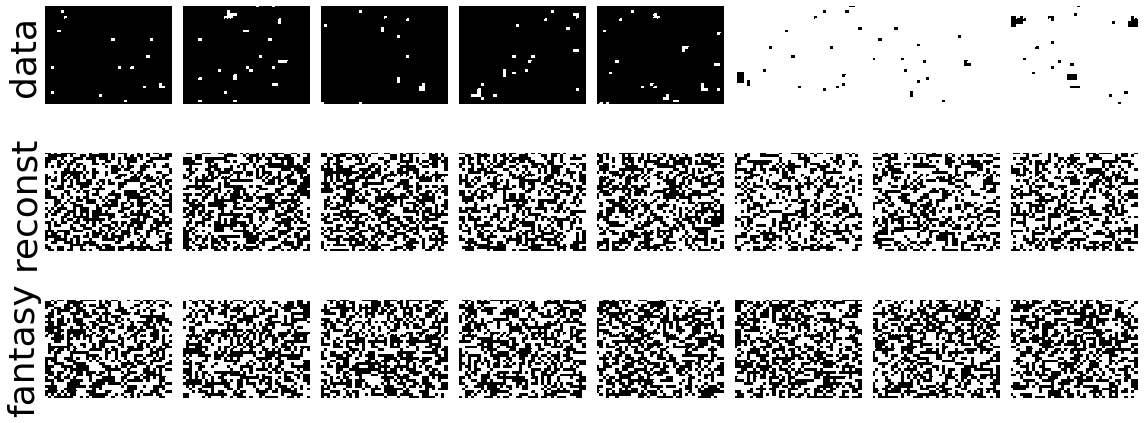

training in the critical phase
layerwise pretraining
training model 0

Before training:
-ReconstructionError: 1.415932
-EnergyCoefficient: 0.168717
-HeatCapacity: 0.086845
-WeightSparsity: 0.335200
-WeightSquare: 1.903544
-KLDivergence: 0.418750
-ReverseKLDivergence: 0.016154

End of epoch 1: 
Time elapsed 1.945s
-ReconstructionError: 1.406319
-EnergyCoefficient: 0.163837
-HeatCapacity: 0.086406
-WeightSparsity: 0.334989
-WeightSquare: 1.912629
-KLDivergence: 0.419178
-ReverseKLDivergence: 0.009721

End of epoch 2: 
Time elapsed 1.894s
-ReconstructionError: 1.406428
-EnergyCoefficient: 0.163416
-HeatCapacity: 0.095853
-WeightSparsity: 0.334077
-WeightSquare: 1.936154
-KLDivergence: 0.418361
-ReverseKLDivergence: 0.010860

End of epoch 3: 
Time elapsed 1.942s
-ReconstructionError: 1.404644
-EnergyCoefficient: 0.163221
-HeatCapacity: 0.089165
-WeightSparsity: 0.331146
-WeightSquare: 1.995652
-KLDivergence: 0.418375
-ReverseKLDivergence: 0.010820

End of epoch 4: 
Time elapsed 1.869s
-Rec

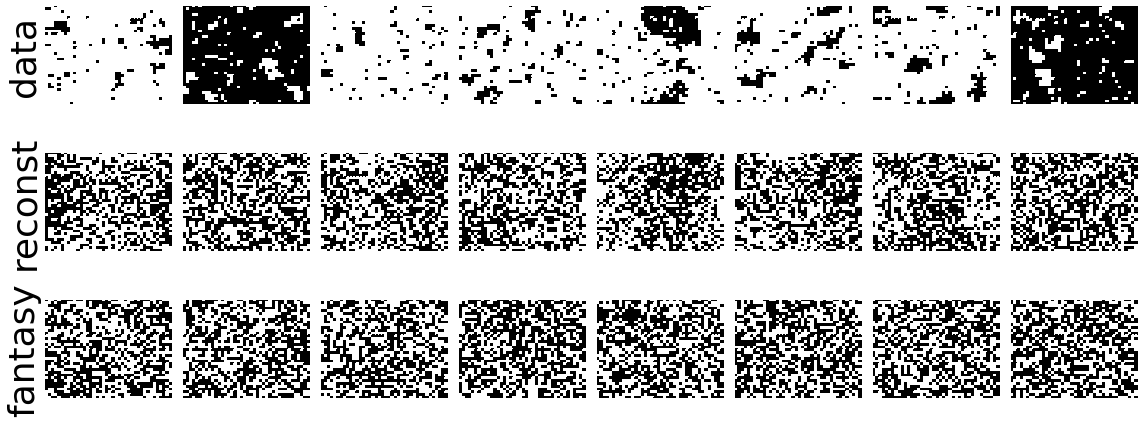

training in the disordered phase
layerwise pretraining
training model 0

Before training:
-ReconstructionError: 1.410001
-EnergyCoefficient: 0.110492
-HeatCapacity: 0.092223
-WeightSparsity: 0.337057
-WeightSquare: 1.902251
-KLDivergence: 0.030492
-ReverseKLDivergence: 0.014561

End of epoch 1: 
Time elapsed 2.062s
-ReconstructionError: 1.413065
-EnergyCoefficient: 0.100761
-HeatCapacity: 0.086829
-WeightSparsity: 0.335294
-WeightSquare: 1.943940
-KLDivergence: 0.030426
-ReverseKLDivergence: 0.010565

End of epoch 2: 
Time elapsed 1.899s
-ReconstructionError: 1.411849
-EnergyCoefficient: 0.100620
-HeatCapacity: 0.074392
-WeightSparsity: 0.332099
-WeightSquare: 2.016817
-KLDivergence: 0.030483
-ReverseKLDivergence: 0.010048

End of epoch 3: 
Time elapsed 1.925s
-ReconstructionError: 1.404504
-EnergyCoefficient: 0.101234
-HeatCapacity: 0.050446
-WeightSparsity: 0.319267
-WeightSquare: 2.294243
-KLDivergence: 0.030219
-ReverseKLDivergence: 0.010214

End of epoch 4: 
Time elapsed 1.895s
-R

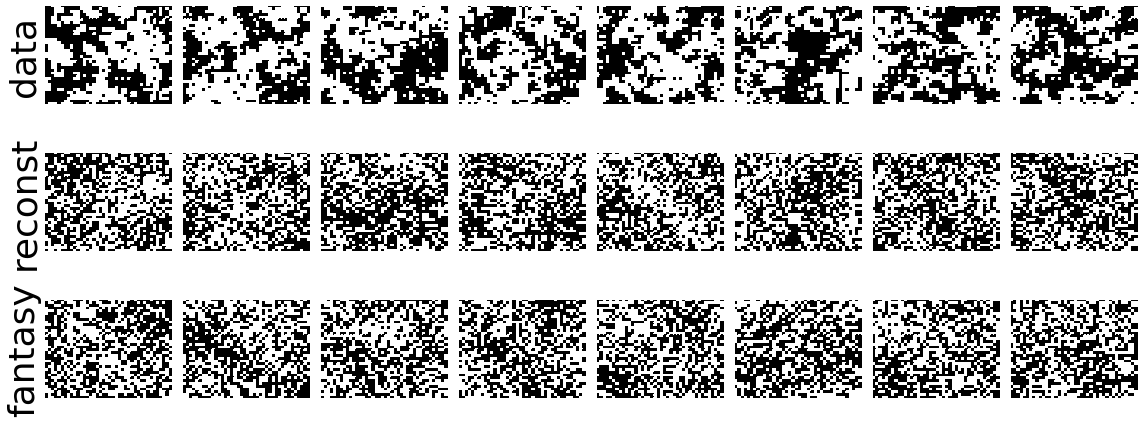

In [4]:
image_shape = (40,40) # 40x40=1600 spins in every configuration
num_to_plot = 8 # of data points to plot

# parameters the user needs to choose
batch_size = 100 # batch size
num_epochs = 10 # training epochs
monte_carlo_steps = 2 # number of MC sampling steps
initial = 1E-3 # initial learning rate
coefficient = 1.0 # controls learning rate decay
num_fantasy_steps = 100 # MC steps when drawing fantasy particles
lmbda = 1E-6 # stength of the L1 penalty
num_hidden_units = [80, 8] # hidden layer units

# load data
data =  Load_Ising_Dataset()

# preallocate data dicts
dbm_L1_reconstructions = {}
dbm_L1_fantasy = {}
true_examples = {}
dbm_models = {}

for phase in ['ordered','critical','disordered']:
    print('training in the {} phase'.format(phase))

    # set up an object to read minibatch of the data
    transform = pre.Transformation()
    batch_reader = batch.in_memory_batch(data[phase], batch_size, train_fraction=0.95, transform=transform)
    batch_reader.reset_generator(mode='train')

    ##### Bernoulli RBM
    dbm_L1 = BoltzmannMachine(
            [BernoulliLayer(batch_reader.ncols)] + \
            [BernoulliLayer(n) for n in num_hidden_units]
            )

    # add an L1 penalty to the weights
    for j_, conn in enumerate(dbm_L1.connections):
        conn.weights.add_penalty({'matrix': pen.l1_penalty(lmbda)})

    # train the model
    train_model(dbm_L1, batch_reader, num_epochs, monte_carlo_steps)

    # store model
    dbm_models[phase]=dbm_L1

    # reset the generator to the beginning of the validation set
    batch_reader.reset_generator(mode='validate')
    examples = batch_reader.get(mode='validate') # shape (batch_size, 1600)
    true_examples[phase] = examples[:num_to_plot]

    # compute reconstructions
    reconstructions = compute_reconstructions(dbm_L1, true_examples[phase])
    dbm_L1_reconstructions[phase] = reconstructions

    # compute fantasy particles
    fantasy_particles = compute_fantasy_particles(dbm_L1,
                                                  num_to_plot,
                                                  num_fantasy_steps,
                                                  mean_field=False)
    dbm_L1_fantasy[phase] = fantasy_particles

    # plot results and save fig
    reconstruction_plot = plot_image_grid(
            np.array([
                    true_examples[phase],
                    dbm_L1_reconstructions[phase],
                    dbm_L1_fantasy[phase]
                    ]),
            image_shape, vmin=0, vmax=1,
            row_titles=["data", "reconst", "fantasy"],
            filename='DBM_Ising-'+phase+'.png')

# save data
save_file_name='./DBM_ising_training_data-L=40.pkl'
pickle.dump([dbm_models, true_examples, dbm_L1_fantasy, dbm_L1_reconstructions,
            image_shape, num_to_plot, batch_size, num_epochs, monte_carlo_steps,
            initial, coefficient, num_fantasy_steps, lmbda,num_hidden_units,
            ], open(save_file_name, "wb" ) )

## Excercises

* Pick different temperatures $T$ from the available set and repeat the learning procedure. Can you find more suitable hyperparameters (such as the number of hidden units, the learning rate, the reglarization strength, and the SGD optimizer parameters) that give better results?
* Generate a large enough set of fantasy particles and compute their magnetization, energy (and other thermodynamic quantities). Comparing these values to the original MC samples provides a useful measure for the performance of the DBM.  
* You can now play the following game: use the RBM to generate a large sample of Ising states, and then apply your pre-trained DNN or CNN classifier from Secs IX and XI to label them. 

* Generate a large enough set of fantasy particles and compute their magnetization, energy (and other thermodynamic quantities). Comparing these values to the original MC samples provides a useful measure for the performance of the DBM.  

In [33]:
N = 40

def calcEnergy(config):
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = -S*((config[(i+1)%N,j]) + 
            (config[i,(j+1)%N]) + 
            (config[(i-1)%N,j]) + 
            (config[i,(j-1)%N]))
            energy += nb
    return energy

def calcMag(config):
    mag = np.sum(config)
    return mag**2

def comparation():
    
    with open(os.path.join(".", "DBM_ising_training_data-L=40.pkl"), 'rb') as infile:
        data = pickle.load(infile)
    
    orig_data = data[1]
    fant_data = data[2]
    
    for phase in ['ordered','critical','disordered']:
        orig_data_phase = orig_data[phase]
        fant_data_phase = fant_data[phase]
        orig_data_phase = orig_data_phase.reshape((8, N, N))
        fant_data_phase = fant_data_phase.reshape((8, N, N))
        
        energyT_orig = 0
        energyT_fant = 0
        
        magT_orig = 0
        magT_fant = 0
        for i in range(0, 8):
            energyT_orig += calcEnergy(orig_data_phase[i])
            energyT_fant += calcEnergy(fant_data_phase[i])
            
            magT_orig += calcMag(orig_data_phase[i])
            magT_fant += calcMag(fant_data_phase[i])
        
        diff_mag = 100*abs((magT_orig - magT_fant)/magT_orig)
        diff_energy = 100*abs((energyT_orig - energyT_fant)/energyT_orig)
        print('Diferencia para fase {} en energía es {}%'.format(phase, diff_energy))
        print('Diferencia para fase {} en magnetizacion es {}%'.format(phase, diff_energy))

In [34]:
comparation()

Diferencia para fase ordered en energía es 57.58216413607534%
Diferencia para fase ordered en magnetizacion es 57.58216413607534%
Diferencia para fase critical en energía es 2.1989528795811517%
Diferencia para fase critical en magnetizacion es 2.1989528795811517%
Diferencia para fase disordered en energía es 25.498142519419115%
Diferencia para fase disordered en magnetizacion es 25.498142519419115%
